# New atom assignments plots as of 27th August 2025
#### read in result from token_level_prototype.ipynb '/scratch/ifender/SOS_tmp/embeddings_pretrainingdata/combined_pretraining_annotations.csv'

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from constants import SEED
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from collections import Counter
import logging
import seaborn as sns
import os
import re
from pathlib import Path

/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
def plot_legend(legend_elements, save_path, alpha, color):
    cm = 1/2.54 
    fig, ax = plt.subplots(figsize=(8.3*cm, 2*cm))  # Adjust the size as needed
    ax.legend(handles=legend_elements, loc='center', fontsize=12, ncol=len(legend_elements), markerscale=2)
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(f"{save_path}_LEGEND_alpha{alpha}_col{color}_newnoyelligblu.svg", format="svg", dpi=600, bbox_inches='tight')
    fig.clf()
    
def build_legend(data, markerdict, labels):
    """
    Build a legend for matplotlib plt from dict
    """
    # Count how often which label appears in the dataset
    label_counts = {label: labels.count(label) for label in set(labels)}
    legend_elements = []
    for key in data:
        if key not in labels:
            continue
        # Create label for legend that contains number of occurrences
        legend_label = f"{key} ({label_counts.get(key, 0)})"
        legend_elements.append(Line2D([0], [0], marker=markerdict[key], color='w', label=legend_label,
                                      markerfacecolor=data[key], markersize=9))
    return legend_elements

def plot_pca_with_markers_seaborn(embeddings, labels, marker_dict, colours_dict, save_path, namestring, color, alpha):
    """Performing PCA and plotting it

    Args:
        embeddings (_list[float]_): Embeddings of one element or a subgroup
        labels (_list[string]_): List of assigned atom types
        colours_dict (_dict[string][int]_): Dictionary of colors linking atomtypes to colors
        save_path (_string_): Path where to save plot
        alpha (float, optional): Level of opacity.
    """
    #inches to centimeters
    cm = 1/2.54 
    logging.info("Started plotting PCA")
    #before PCA I want to make sure not to plot atom types where less them 10 of those exist
    # filter out atom types and emebddings where less than 10 of those exist
    filtered_labels = []
    filtered_embeddings = []
    for label, emb in zip(labels, embeddings):
        #if labels.count(label) > 100:
        filtered_labels.append(label)
        filtered_embeddings.append(emb)

    #print("Filtered vs. unfiltered:", len(filtered_labels), len(labels))
    labels = filtered_labels
    embeddings = filtered_embeddings
    
    print("markerdict:",marker_dict)
    os.makedirs(save_path.parent, exist_ok=True)
    pca = PCA(n_components=2, random_state=SEED + 6541)
    pca_embeddings = pca.fit_transform(embeddings)
    logging.info(
        f"{save_path} has the explained variance of {pca.explained_variance_ratio_}"
    )
    explained_variance_percentages = [f"{var:.2%}" for var in pca.explained_variance_ratio_]  # Format as percentages
    
    # sort labels so plotting most frequent first and least frequent will be plotted on top
    label_counts = Counter(labels)
    sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)
    print("sorted labels:",sorted_labels)
    #rep = save_path.name.split('pca')[0]
    #fig, ax = plt.subplots(1, figsize=(8.3*cm, 8.3*cm)) #8.3cm is one column figure (10cm x 8.3 cm)
    
    # Create a DataFrame for Seaborn
    import pandas as pd
    data = pd.DataFrame({
        'PC1': pca_embeddings[:, 0],
        'PC2': pca_embeddings[:, 1],
        'label': labels
    })
    
    # Create a JointGrid
    g = sns.JointGrid(data=data, x='PC1', y='PC2', height=8.5*cm)
    
    print(f"colours dict: {colours_dict}")
    # Plot the scatter plot with markers
    for label in sorted_labels:
        marker = marker_dict[label]
        idx = data['label'] == label
        col = colours_dict[label]
        sns.scatterplot(data=data[idx], x='PC1', y='PC2', ax=g.ax_joint, marker=marker, color=col, alpha=alpha)
        
    # Add KDE plots on the sides for each label
    for label in sorted_labels:
        idx = data['label'] == label
        col = colours_dict[label]
        sns.kdeplot(data=data[idx], x='PC1', ax=g.ax_marg_x, color=col, alpha=alpha)
        sns.kdeplot(data=data[idx], y='PC2', ax=g.ax_marg_y, color=col, alpha=alpha)
        
    # Set labels and title
    g.ax_joint.set_xlabel(f"PC 1 ({explained_variance_percentages[0]})", fontsize=12)
    g.ax_joint.set_ylabel(f"PC 2 ({explained_variance_percentages[1]})", fontsize=12)
    #g.ax_joint.set_title(f"PCA for {rep} of element {namestring}", fontsize=12)
    
    # Customize spines
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.spines['left'].set_linewidth(2)
    g.ax_joint.spines['bottom'].set_linewidth(2)
    # Set tick parameters
    g.ax_joint.tick_params(length=8, width=1, labelsize=12)
    
    # Set major tick locators
    g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
    g.ax_joint.yaxis.set_major_locator(MultipleLocator(10))
    
    # Set aspect ratio
    g.ax_joint.set_aspect('equal', adjustable='box')
    
    # Calculate the limits for the axes
    x_min, x_max = data['PC1'].min(), data['PC1'].max()
    y_min, y_max = data['PC2'].min(), data['PC2'].max()
    axis_min = min(x_min, y_min)
    axis_max = max(x_max, y_max)
    margin = 0.08 * (axis_max - axis_min) + 0.1 # 5% margin
    
    # Set the same limits for both axes with margins
    g.ax_joint.set_xlim(axis_min - margin, axis_max + margin)
    g.ax_joint.set_ylim(axis_min - margin, axis_max + margin)
    
    legend_elements = build_legend(colours_dict, marker_dict, labels)
    plot_legend(legend_elements, save_path, alpha, color)

    plt.tight_layout()
    plt.show()
    #plt.subplots_adjust(bottom=0.4)
     # Set ticks every 10 units
    g.savefig(f"{save_path}_withmarkers_alpha{alpha}_col{color}).svg", format="svg", dpi=600, bbox_inches='tight')
    #plt.close()


def colorstoatomtypesbyelement(atomtoelems_dict):
    """Generating a dictionary of colors given a dictionary that maps atomtypes to elements

    Args:
        atomtoelems_dict (_dict_): Dictionary that maps atom types to elements

    Returns:
        _dict,: Dictionary that maps atom types to colors
    """
    # https://sashamaps.net/docs/resources/20-colors/ #95% accessible only, subject to change, no white
    sash = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4',
                   '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#000000']
    #viridis
    viridis = plt.cm.get_cmap('viridis', 8)  # Get the Viridis colormap
    viridis_colors = [mcolors.to_hex(viridis(i)) for i in range(8)]  # Convert to hex 
    # tol colorscale https://personal.sron.nl/~pault/ 

    #        purple, dark blue, light blue, green,    light green, yellow,     orange,      red 
    #tol = ['#882e72', '#1965B0', '#7bafde', '#4eb265', '#cae0ab', '#f7f056', '#f1932d', '#dc050c'] 
    # 9 10 14 15 17 18 26, but switched pos of bright blue with orange
    #        purple, dark blue,   orange,    green, light green,     yellow,    red,     light blue --> in this order light blue should never be used
    #tol = ['#882e72', '#1965B0', '#f1932d', '#4eb265', '#cae0ab', '#f7f056',   '#dc050c', '#7bafde'] 
    #        purple, dark blue,   orange,    green, light green,     dark blue again,    red,     light blue --> in this order light blue should never be used, dark blue used twice, but thats okay, never occurs twice together
    # dark blue twice appearing is okay, because it never appears twice in a plot together
    tol = ['#882e72', '#1965B0', '#f1932d', '#4eb265', '#cae0ab', '#1965B0',   '#dc050c', '#7bafde'] 
    # change to 9 10 skip 14 15 17 18 26
    #tol = ['#882e72','#1965B0',  '#4eb265', '#cae0ab', '#f7f056', '#f1932d', '#dc050c']
    
    markers = ["o", "s", "X", "D", "P", "^", "X", "v",  "P", "*"]
    
    # create dict for colors
    colornames=['sash', 'tol', 'viridis']
    colors = [sash, tol, viridis_colors]
    colordict = dict()

    for colourname, colour in zip(colornames,colors):
        colordict[colourname]={}
        for key in atomtoelems_dict.keys():
            atypes = atomtoelems_dict[key]
            keycoldict=dict()
            for at, col in zip(atypes, colour[0:len(atypes)]):
                keycoldict[at]=col    
            colordict[colourname][key]=keycoldict 
    print(colordict.items())
    print(colordict['sash'])
    
    # create dict for markers
    markerdict = dict()
    for key in atomtoelems_dict.keys():
            atypes = atomtoelems_dict[key]
            markerdictdict=dict()
            i=0
            for at in atypes:
                markerdictdict[at]=markers[i]
                i+=1  
            markerdict[key]=markerdictdict
    print(markerdict.items())
    return colordict, markerdict


# Read in annotations dataframe

In [3]:
# read in atom annotations (contains embeddings of 6 different models per atom)
#annotations = "/scratch/ifender/SOS_tmp/embeddings_pretrainingdata/combined_pretraining_annotations.csv"
annotations = "/scratch/ifender/SOS_tmp/embeddings_pretrainingdata_kekulized/combined_pretraining_kekulized_annotations.csv"
df = pd.read_csv(annotations)
print(df.head())

   Unnamed: 0                   SMILES  SMILES_pos smiles_token label  \
0           0  CC(C)NC(=S)N1CCOC(C)C1C           0            C    c3   
1           1  CC(C)NC(=S)N1CCOC(C)C1C           1            C    c3   
2           2  CC(C)NC(=S)N1CCOC(C)C1C           3            C    c3   
3           3  CC(C)NC(=S)N1CCOC(C)C1C           5            N    ns   
4           4  CC(C)NC(=S)N1CCOC(C)C1C           6            C    cs   

   SMILES_BART_emb_0  SMILES_BART_emb_1  SMILES_BART_emb_2  SMILES_BART_emb_3  \
0           0.767342          -2.148449          -0.830757           1.026623   
1           0.235064          -1.534703          -0.812818           1.416120   
2           0.509966          -1.646366          -0.493673           1.272166   
3           0.462140          -2.198378          -0.478500           1.262209   
4           0.067159          -2.079316          -0.281959           1.124314   

   SMILES_BART_emb_4  ...  SMILES_untrained_emb_759  SMILES_untrained_emb_

In [ ]:
# extract all the unique SMILES --> to use for kekulized version
#unique_smiles = df["SMILES"].unique()
#print(len(unique_smiles))
# write them to a .csv
#pd.DataFrame(unique_smiles, columns=["SMILES"]).to_csv("/scratch/ifender/SOS_tmp/embeddings_pretrainingdata/365unique_smiles_of_pretraining_passing_pipeline.csv", index=False)

365


In [ ]:
#df =pd.read_csv("/scratch/ifender/SOS_tmp/embeddings_pretrainingdata/365unique_smiles_of_pretraining_passing_pipeline.csv")
#print(len(df))
#print(list(df['SMILES']))

365
['CC(C)NC(=S)N1CCOC(C)C1C', 'CC(C)NC(=S)N1CCO[C@@H](C)[C@H]1C', 'c1cc(-c2ccsc2)c2cc[nH]c2n1', 'NC(=O)C(SCc1cccc2ccccc12)c1ccc(F)cc1', 'NC(=O)[C@H](SCc1cccc2ccccc12)c1ccc(F)cc1', 'COCCCNC(=O)CNC(=O)Cc1ccccc1', 'CC1CNC(=O)N(C2CC2)C1=O', 'C[C@@H]1CNC(=O)N(C2CC2)C1=O', 'CCCCSCC(C)(C)C(O)c1ccccc1', 'CCCCSCC(C)(C)[C@@H](O)c1ccccc1', 'O=S(=O)(P)Oc1cccc(C2CCCCC2)c1C1CCCCC1', 'O=S(=O)([P@H2])Oc1cccc(C2CCCCC2)c1C1CCCCC1', 'COc1ccc(C=O)c2c1sc1ccccc12', 'CC(C)=CCNc1cnccc1C#N', 'Cn1ncc(-c2ccccc2C2CCCCC2)c1N', 'COC(=O)c1cc(C#N)c(C2CC2)[nH]1', 'CCN(CC1CCC1)S(=O)(=O)c1ccsc1CO', 'COc1cccc2c1C(O)(C1CC1)CCC2', 'COc1cccc2c1[C@](O)(C1CC1)CCC2', 'CN(C)c1ccc(C=NCCCCO)cc1', 'CN(C)c1ccc(/C=N/CCCCO)cc1', 'COc1cc(SC)c(OC)cc1CNC(=O)C#N', 'CC(C)(O)C1CCCN1C(=O)c1cccc(-n2cccn2)n1', 'CC(C)(O)[C@@H]1CCCN1C(=O)c1cccc(-n2cccn2)n1', 'CSCC(O)CC(=O)Nc1ccccc1', 'CSC[C@H](O)CC(=O)Nc1ccccc1', 'COC1CCCCC1SC1CCCCC1OC', 'CO[C@H]1CCCC[C@@H]1S[C@@H]1CCCC[C@H]1OC', 'c1cnc(-c2ncn3ccccc23)nc1', 'CCC(C#N)S(=O)(=O)NC1(C#N)CCCCC1', 

In [4]:
# Add in column for embeddings as array
model_prefixes = [
    "SMILES_BART_emb_",
    "SMILES_roberta_emb_",
    "SMILES_untrained_emb_",
    #"SELFIES_BART_emb_",
    #"SELFIES_roberta_emb_",
    #"SELFIES_untrained_emb_"
]

for prefix in model_prefixes:
    cols = cols = [col for col in df.columns if re.match(fr"{prefix}\d+$", col)]
    df[f"{prefix}array"] = [np.array(row) for row in df[cols].values]
    print(len(df[f"{prefix}array"]))
    
# and making sure columns have correct length
print(df.columns)

#print(len(df['SELFIES_untrained_emb_array'][0]))
for model_prefix in model_prefixes:
    print(len(df[f"{model_prefix}array"][0]))
    print(df[f"{model_prefix}array"][0].shape)

6963
6963
6963
Index(['Unnamed: 0', 'SMILES', 'SMILES_pos', 'smiles_token', 'label',
       'SMILES_BART_emb_0', 'SMILES_BART_emb_1', 'SMILES_BART_emb_2',
       'SMILES_BART_emb_3', 'SMILES_BART_emb_4',
       ...
       'SMILES_untrained_emb_762', 'SMILES_untrained_emb_763',
       'SMILES_untrained_emb_764', 'SMILES_untrained_emb_765',
       'SMILES_untrained_emb_766', 'SMILES_untrained_emb_767', 'Element',
       'SMILES_BART_emb_array', 'SMILES_roberta_emb_array',
       'SMILES_untrained_emb_array'],
      dtype='object', length=2313)
768
(768,)
768
(768,)
768
(768,)


In [5]:
ol = ['#882e72', '#1965B0', '#f1932d', '#4eb265', '#cae0ab', '#1965B0',  '#dc050c', '#7bafde'] 
colourdict = {'C': {'c3': '#4eb265','ca':'#1965B0', 'c': '#882e72','c2': '#f1932d', 'cc': '#dc050c', 'cd':  '#7bafde' }, 'O': {'o':  '#882e72', 'oh':  '#1965B0', 'os': '#f1932d'}, 'N': {'ns':  '#882e72' ,'na': '#1965B0' , 'nb': '#4eb265', 'nd':  '#f1932d'}}

markerdict = {'C': {'c3':"D", 'ca':"P", 'c':"o",'c2': "X", 'cc':"*", 'cd': "^" }, 'O': {'o':  "o", 'os': "X", 'oh': "s"}, 'N': {'ns': "o" ,'na': "^" , 'nb': "X", 'nd':  "D"}}

Element C
c3    2397
ca    1991
c      267
cc     190
cd     154
c2     141
cx      73
ce      60
cy      33
cp      30
cg      19
c1      16
cs      13
cf      10
ch       2
cq       2
Name: label, dtype: int64
Atom types with thresh > 100 for C: ['c3' 'ca' 'cc' 'cd' 'c' 'c2']
MODEL: SMILES_BART_emb_########################################################################################################################
Embeddings shape for C and SMILES_BART_emb_: (1008, 768)
markerdict: {'c3': 'D', 'ca': 'P', 'c': 'o', 'c2': 'X', 'cc': '*', 'cd': '^'}
sorted labels: ['c3', 'ca', 'c', 'c2']
colours dict: {'c3': '#4eb265', 'ca': '#1965B0', 'c': '#882e72', 'c2': '#f1932d', 'cc': '#dc050c', 'cd': '#7bafde'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


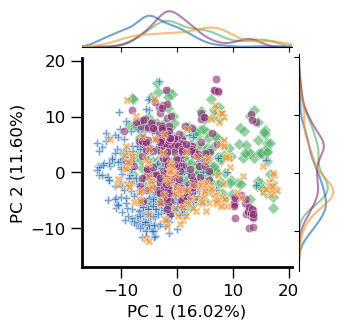

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_roberta_emb_########################################################################################################################
Embeddings shape for C and SMILES_roberta_emb_: (1008, 768)
markerdict: {'c3': 'D', 'ca': 'P', 'c': 'o', 'c2': 'X', 'cc': '*', 'cd': '^'}
sorted labels: ['c3', 'ca', 'c', 'c2']
colours dict: {'c3': '#4eb265', 'ca': '#1965B0', 'c': '#882e72', 'c2': '#f1932d', 'cc': '#dc050c', 'cd': '#7bafde'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


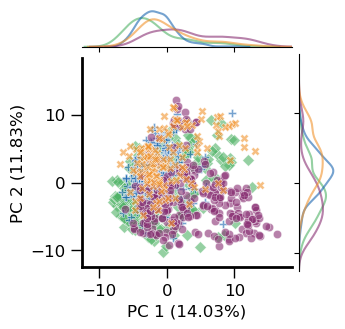

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_untrained_emb_########################################################################################################################
Embeddings shape for C and SMILES_untrained_emb_: (1008, 768)
markerdict: {'c3': 'D', 'ca': 'P', 'c': 'o', 'c2': 'X', 'cc': '*', 'cd': '^'}
sorted labels: ['c3', 'ca', 'c', 'c2']
colours dict: {'c3': '#4eb265', 'ca': '#1965B0', 'c': '#882e72', 'c2': '#f1932d', 'cc': '#dc050c', 'cd': '#7bafde'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


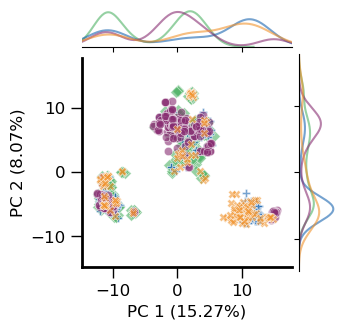

<Figure size 326.772x78.7402 with 0 Axes>

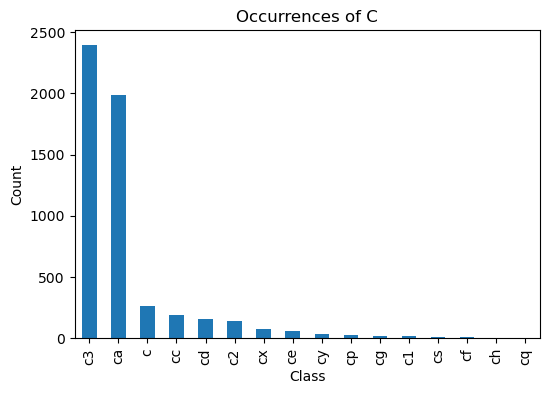

Element N
ns    130
nb     83
na     80
nd     66
n      54
nu     48
nc     32
nv     31
n1     30
nh     23
n2     21
n7     12
n3      9
n8      7
nt      7
nj      2
ne      1
Name: label, dtype: int64
Atom types with thresh > 60 for N: ['ns' 'na' 'nb' 'nd']
MODEL: SMILES_BART_emb_########################################################################################################################
Embeddings shape for N and SMILES_BART_emb_: (359, 768)
markerdict: {'ns': 'o', 'na': '^', 'nb': 'X', 'nd': 'D'}
sorted labels: ['ns', 'nb', 'na', 'nd']
colours dict: {'ns': '#882e72', 'na': '#1965B0', 'nb': '#4eb265', 'nd': '#f1932d'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


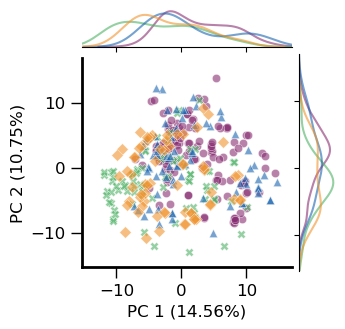

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_roberta_emb_########################################################################################################################
Embeddings shape for N and SMILES_roberta_emb_: (359, 768)
markerdict: {'ns': 'o', 'na': '^', 'nb': 'X', 'nd': 'D'}
sorted labels: ['ns', 'nb', 'na', 'nd']
colours dict: {'ns': '#882e72', 'na': '#1965B0', 'nb': '#4eb265', 'nd': '#f1932d'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


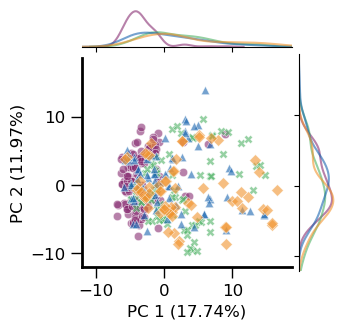

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_untrained_emb_########################################################################################################################
Embeddings shape for N and SMILES_untrained_emb_: (359, 768)
markerdict: {'ns': 'o', 'na': '^', 'nb': 'X', 'nd': 'D'}
sorted labels: ['ns', 'nb', 'na', 'nd']
colours dict: {'ns': '#882e72', 'na': '#1965B0', 'nb': '#4eb265', 'nd': '#f1932d'}


/tmp/ipykernel_3424202/2976650807.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


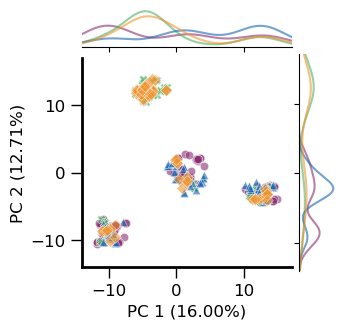

<Figure size 326.772x78.7402 with 0 Axes>

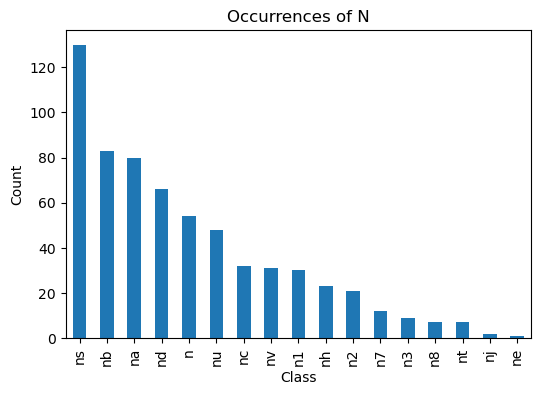

Element S
ss    86
sy    19
s     13
s6    11
sh     4
s4     2
sq     1
Name: label, dtype: int64
Atom types with thresh > 60 for S: ['ss']


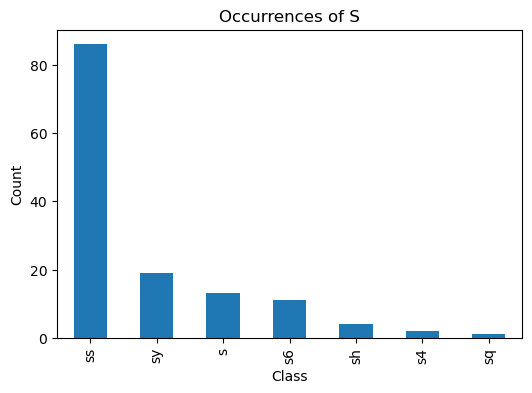

Element O
o     337
os    275
oh     95
op      3
Name: label, dtype: int64
Atom types with thresh > 60 for O: ['os' 'o' 'oh']
MODEL: SMILES_BART_emb_########################################################################################################################
Embeddings shape for O and SMILES_BART_emb_: (670, 768)
markerdict: {'o': 'o', 'os': 'X', 'oh': 's'}
sorted labels: ['o', 'os', 'oh']
colours dict: {'o': '#882e72', 'oh': '#1965B0', 'os': '#f1932d'}


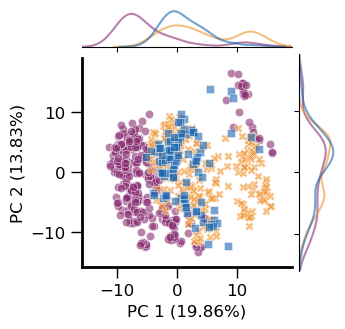

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_roberta_emb_########################################################################################################################
Embeddings shape for O and SMILES_roberta_emb_: (670, 768)
markerdict: {'o': 'o', 'os': 'X', 'oh': 's'}
sorted labels: ['o', 'os', 'oh']
colours dict: {'o': '#882e72', 'oh': '#1965B0', 'os': '#f1932d'}


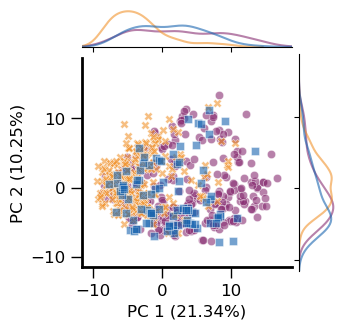

<Figure size 326.772x78.7402 with 0 Axes>

MODEL: SMILES_untrained_emb_########################################################################################################################
Embeddings shape for O and SMILES_untrained_emb_: (670, 768)
markerdict: {'o': 'o', 'os': 'X', 'oh': 's'}
sorted labels: ['o', 'os', 'oh']
colours dict: {'o': '#882e72', 'oh': '#1965B0', 'os': '#f1932d'}


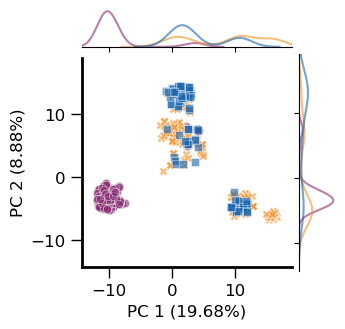

<Figure size 326.772x78.7402 with 0 Axes>

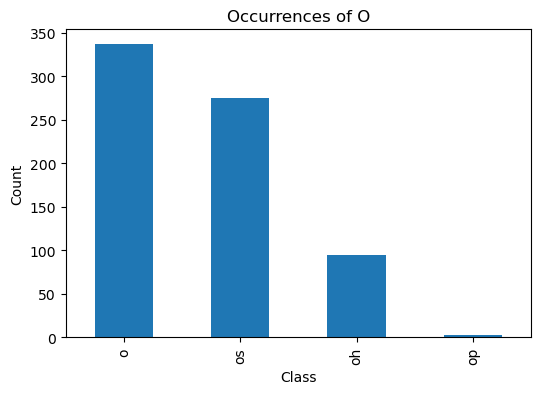

Element F
f    66
Name: label, dtype: int64
Atom types with thresh > 60 for F: ['f']


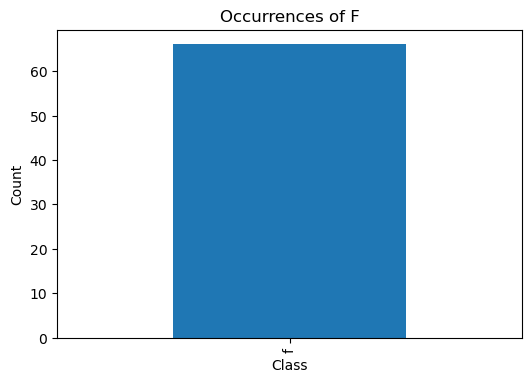

Element P
p5    7
p3    2
Name: label, dtype: int64
Atom types with thresh > 60 for P: []


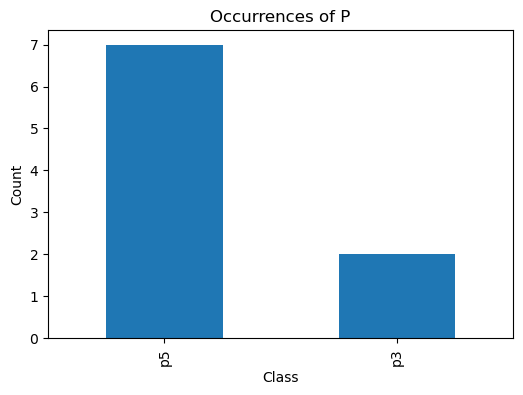

Element I
i    8
Name: label, dtype: int64
Atom types with thresh > 60 for I: []


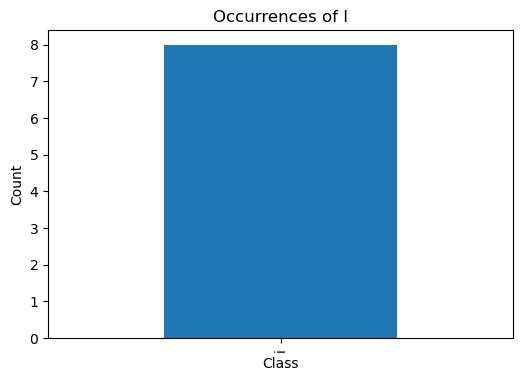

In [6]:
for element in df.Element.unique():
    print(f"Element {element}")
    class_counts = df[df.Element==element]["label"].value_counts()
    print(class_counts)
    # select all rows of df that correspond to the current element and have more than 100 entries
    if element!='C':
        thresh=60
    else:
        thresh = 100
    element_rows = df[df.Element==element]
    element_rows = element_rows[element_rows["label"].map(element_rows["label"].value_counts()) > thresh]
    # tell me all the atom types this includes
    atom_types = element_rows['label'].unique()
    print(f"Atom types with thresh > {thresh} for {element}: {atom_types}")
    
    if element=='C':
        # then exclude atom types cc and cd, they cannot be described well
        element_rows = element_rows[~element_rows["label"].isin(["cc", "cd"])]

    # Downsample each atom type to max 300 rows
    element_rows_downsampled = (
        element_rows.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(n=min(len(x), 300), random_state=SEED))
    )
    
    if len(atom_types)>2:
        # iterate through the rows at the same time and create two arrays, one for labels, one for that specific embedding type
        for prefix in model_prefixes:
            print(f"MODEL: {prefix}########################################################################################################################")
            embeddings = np.stack(element_rows_downsampled[f"{prefix}array"].values)
            labels = element_rows_downsampled["label"].tolist()
            print(f"Embeddings shape for {element} and {prefix}: {embeddings.shape}")
            
            marker_dict=markerdict[element]
            colours_dict=colourdict[element]
            base_dir=Path('/home/ifender/SOS/SMILES_or_SELFIES/atomtype_embedding_visualisation/28_8_AtomEmbedsPlots_kekulized_downsampled/')
            namestring=''
            save_prefix = f"{element}_{prefix}_pca"
            save_path = base_dir / save_prefix
            # do PCA on atom types and plot scatter plot
            color='tol'
            alpha=0.6
            plot_pca_with_markers_seaborn(embeddings, labels, marker_dict, colours_dict, save_path, namestring, color, alpha)
            

    # Plot bar chart
    class_counts.plot(kind='bar', figsize=(6,4), title=f'Occurrences of {element}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()